In [1]:
%load_ext autoreload
%matplotlib inline

In [7]:
#from fastai.imports import *
#from fastai.structured import*

import pandas as pd
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2, venn2_circles
#from Ipython.display import display

from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

import os
print(os.getcwd())

/home/vishy/Desktop/Myfiles/AV/AMEX


<Figure size 864x360 with 0 Axes>

In [3]:
PATH = "/home/vishy/Desktop/Myfiles/AV/AMEX/"

In [4]:
!ls {PATH}

18.ipynb		  lgb_xgb_5fold_v2.csv	sample_submission_2s8l9nF.csv
21.ipynb		  lgb_xgb_5fold_v3.csv	stack_1.ipynb
22.ipynb		  models		test.csv
AMX.ipynb		  more_xgb_1.csv	test_LNMuIYp.zip
basic_xgb_2.csv		  more_xgb_2.csv	tmp
basic_xgb_3.csv		  more_xgb_3.csv	train_amex.zip
basic_xgb.csv		  more_xgb_4.csv	train.csv
FastAi-DL.ipynb		  more_xgb_5.csv	xgb_5fold_2.csv
historical_user_logs.csv  more_xgb_6.csv	xgb_5fold.csv
less_xgb_2.csv		  more_xgb_7.csv	xgb_5fold_v2.csv
lgb_1.csv		  New_LGB.ipynb		XGboost_Basic.ipynb
lgb_2.csv		  New_XGB.ipynb
lgb_xgb_5fold_v1.csv	  New_XGB_LGB2.ipynb


# Importing the data and observe

## train

In [8]:
train = pd.read_csv(PATH+'train.csv', low_memory=False, parse_dates=['DateTime'])
train.rename(columns={'product':'prod'}, inplace=True)
print(train.shape)
train.head()

(463291, 15)


,session_id,DateTime,user_id,prod,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [10]:
display_all(train.isnull().sum().sort_index()/len(train))

DateTime                  0.000000
age_level                 0.039377
campaign_id               0.000000
city_development_index    0.270087
gender                    0.039377
is_click                  0.000000
prod                      0.000000
product_category_1        0.000000
product_category_2        0.789685
session_id                0.000000
user_depth                0.039377
user_group_id             0.039377
user_id                   0.000000
var_1                     0.000000
webpage_id                0.000000
dtype: float64

In [11]:
display_all(train.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
session_id,463291,NaN,NaN,NaN,NaN,NaN,285544,168577,2,137856,285429,435536,595812
DateTime,463291,8610,2017-07-04 20:39:00,173,2017-07-02 00:00:00,2017-07-07 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,463291,NaN,NaN,NaN,NaN,NaN,546050,329463,4,257855,531801,827849,1.14173e+06
prod,463291,10,C,163501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign_id,463291,NaN,NaN,NaN,NaN,NaN,308475,126517,82320,118601,359520,405490,414149
webpage_id,463291,NaN,NaN,NaN,NaN,NaN,29685.9,21542.1,1734,13787,13787,53587,60305
product_category_1,463291,NaN,NaN,NaN,NaN,NaN,3.07243,1.30423,1,2,3,4,5
product_category_2,97437,NaN,NaN,NaN,NaN,NaN,162753,78743.7,18595,82527,146115,254132,450184
user_group_id,445048,NaN,NaN,NaN,NaN,NaN,3.4774,2.41289,0,2,3,4,12
gender,445048,2,Male,393454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
dfs = DataFrameSummary(train)

In [14]:
dfs.columns_types

numeric        10
bool            3
categorical     1
date            1
Name: types, dtype: int64

In [16]:
dfs.columns_stats.T

,counts,uniques,missing,missing_perc,types
session_id,463291,463291,0,0%,numeric
DateTime,463291,8610,0,0%,date
user_id,463291,150347,0,0%,numeric
prod,463291,10,0,0%,categorical
campaign_id,463291,10,0,0%,numeric
webpage_id,463291,9,0,0%,numeric
product_category_1,463291,5,0,0%,numeric
product_category_2,97437,29,365854,78.97%,numeric
user_group_id,445048,13,18243,3.94%,numeric
gender,445048,2,18243,3.94%,bool


## test

In [17]:
test = pd.read_csv(PATH+'test.csv', low_memory=False, parse_dates=['DateTime'])
test.rename(columns={'product':'prod'}, inplace=True)
print(test.shape)
test.head()

(128858, 14)


,session_id,DateTime,user_id,prod,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1
0,411705,2017-07-08,732573,J,404347,53587,1,NaN,5.0,Male,5.0,3.0,NaN,0
1,208263,2017-07-08,172910,I,118601,28529,3,82527.0,NaN,NaN,NaN,NaN,NaN,1
2,239450,2017-07-08,172910,I,118601,28529,4,82527.0,NaN,NaN,NaN,NaN,NaN,1
3,547761,2017-07-08,557318,G,118601,28529,5,82527.0,1.0,Male,1.0,3.0,1.0,0
4,574275,2017-07-08,923896,H,118601,28529,5,82527.0,9.0,Female,3.0,1.0,NaN,1


In [18]:
display_all(test.isnull().sum().sort_index()/len(test))

DateTime                  0.000000
age_level                 0.044111
campaign_id               0.000000
city_development_index    0.268582
gender                    0.044111
prod                      0.000000
product_category_1        0.000000
product_category_2        0.591124
session_id                0.000000
user_depth                0.044111
user_group_id             0.044111
user_id                   0.000000
var_1                     0.000000
webpage_id                0.000000
dtype: float64

In [19]:
display_all(test.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
session_id,128858,NaN,NaN,NaN,NaN,NaN,342584,176743,1,207832,350013,525928,595813
DateTime,128858,2724,2017-07-08 10:28:00,121,2017-07-08 00:00:00,2017-07-09 21:29:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,128858,NaN,NaN,NaN,NaN,NaN,546377,329290,4,259265,530087,826229,1.14171e+06
prod,128858,10,H,44880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign_id,128858,NaN,NaN,NaN,NaN,NaN,233272,137539,82320,105960,118601,360936,414149
webpage_id,128858,NaN,NaN,NaN,NaN,NaN,25789.4,17999,1734,11085,28529,28529,60305
product_category_1,128858,NaN,NaN,NaN,NaN,NaN,3.50505,1.44961,1,2,4,5,5
product_category_2,52687,NaN,NaN,NaN,NaN,NaN,127031,74586.1,18595,82527,82527,146115,450184
user_group_id,123174,NaN,NaN,NaN,NaN,NaN,3.53346,2.4559,0,2,3,4,12
gender,123174,2,Male,108525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def get_venn(axarr, feature):
    axarr[0,0].set_title(f'Overlap between {feature} in train and test')
    venn2([set(train[feature].values), set(test[feature].values)], set_labels = ('train','test'), ax=axarr[0,0])
    
    axarr[0,1].set_title(f'Overlap between {feature} in train and hist')
    venn2([set(train[feature].values), set(hist[feature].values)], set_labels = ('train','hist'), ax=axarr[0,1])
    
    axarr[1,0].set_title(f'Overlap between {feature} in test and hist')
    venn2([set(train[feature].values), set(test[feature].values)], set_labels = ('test','hist'), ax=axarr[1,0])
    
    axarr[1,1].set_title(f'Overlap between {feature} in train and test')
    venn2([set(train[feature].values), set(test[feature].values)], set_labels = ('train','test'), ax=axarr[1,1])

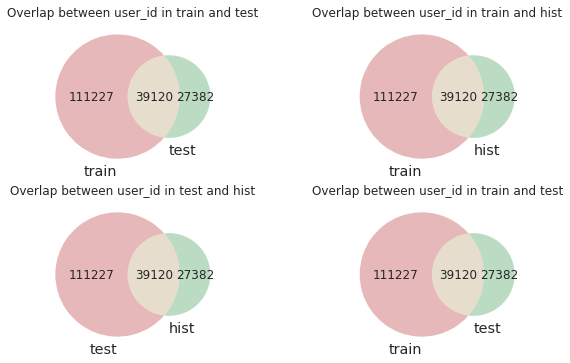

In [23]:
fig, axarr = plt.subplots(2,2, figsize=(10,6))
get_venn(axarr, 'user_id')

## History

In [12]:
hist = pd.read_csv(PATH+'historical_user_logs.csv', low_memory=False, parse_dates=['DateTime'])
hist.rename(columns={'product':'prod'}, inplace=True)
print(hist.shape)
hist.head()

(24287534, 4)


,DateTime,user_id,prod,action
0,2017-05-28 15:44:00,704,B,view
1,2017-05-29 07:08:00,499679,F,view
2,2017-05-29 07:10:00,499679,G,view
3,2017-05-29 07:10:00,499679,G,view
4,2017-05-29 07:10:00,499679,G,view


In [13]:
display_all(hist.isnull().sum().sort_index()/len(hist))

DateTime    0.0
action      0.0
prod        0.0
user_id     0.0
dtype: float64

In [14]:
display_all(hist.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
DateTime,24287534,21452,2017-06-29 20:08:00,2934,2017-05-28 15:44:00,2017-07-01 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,2.42875e+07,NaN,NaN,NaN,NaN,NaN,548458,328577,4,259486,536665,828882,1.14173e+06
prod,24287534,10,H,7972082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
action,24287534,2,view,23854100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Engineering in Train

In [15]:
def handle_missing_inplace(dataset):
    dataset['age_level'].fillna(value=99.0, inplace=True)
    dataset['city_development_index'].fillna(value=99.0, inplace=True)
    dataset['gender'].fillna(value='Unknown', inplace=True)
    dataset['product_category_2'].fillna(value=999999.0, inplace=True)
    dataset['user_depth'].fillna(value=99.0, inplace=True)
    dataset['user_group_id'].fillna(value=99.0, inplace=True)

handle_missing_inplace(train)

In [23]:
display_all(train.isnull().sum().sort_index()/len(train))

DateTime                  0.0
age_level                 0.0
campaign_id               0.0
city_development_index    0.0
day                       0.0
gender                    0.0
hour                      0.0
is_click                  0.0
minute                    0.0
prod                      0.0
product_category_1        0.0
product_category_2        0.0
session_id                0.0
user_depth                0.0
user_group_id             0.0
user_id                   0.0
var_1                     0.0
webpage_id                0.0
dtype: float64

In [16]:
train.columns

Index(['session_id', 'DateTime', 'user_id', 'prod', 'campaign_id',
       'webpage_id', 'product_category_1', 'product_category_2',
       'user_group_id', 'gender', 'age_level', 'user_depth',
       'city_development_index', 'var_1', 'is_click'],
      dtype='object')

In [17]:
cat_vars = ['user_id', 'prod', 'campaign_id','webpage_id', 'product_category_1', 'product_category_2',
             'user_group_id', 'gender', 'age_level', 'user_depth','city_development_index', 'var_1' ]
for v in cat_vars:
    train[v] = train[v].astype('category')
    #test[v]=test[v].astype('category')

In [18]:
#set DateTime as timeseries
train['DateTime'] = pd.to_datetime(train['DateTime'])
#test['click_time'] = pd.to_datetime(test['click_time'])

#set target as_attributed in train as a categorical
train['is_click']=train['is_click'].astype('category')

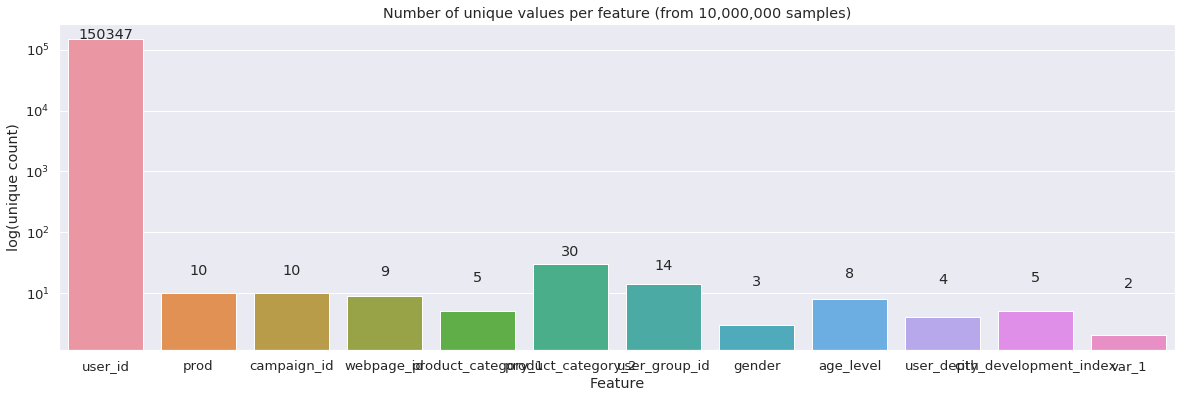

In [19]:
plt.figure(figsize=(20, 6))
cols = ['user_id', 'prod', 'campaign_id','webpage_id', 'product_category_1', 'product_category_2',
             'user_group_id', 'gender', 'age_level', 'user_depth','city_development_index', 'var_1']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 10,000,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

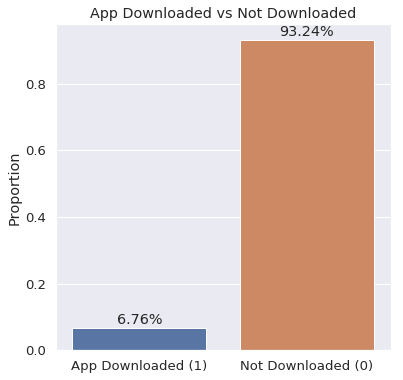

In [20]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.is_click.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

In [21]:
#temporary table to see ips with their associated count frequencies
temp = train['user_id'].value_counts().reset_index(name='counts')
temp.columns = ['user_id', 'counts']
temp[:5]
#Merge counts of user_id wise target
#train= train.merge(temp, on='user_id', how='left')

,user_id,counts
0,658554,255
1,297960,225
2,983136,187
3,422201,157
4,929999,143


In [26]:
train.head(1000)

,session_id,DateTime,user_id,prod,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,day,hour,minute,dow
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,999999.0,10.0,Female,4.0,3.0,3.0,0,0,2,0,0,6
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,999999.0,8.0,Female,2.0,2.0,99.0,0,0,2,0,0,6
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,999999.0,8.0,Female,2.0,2.0,99.0,0,0,2,0,0,6
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,999999.0,3.0,Male,3.0,3.0,2.0,1,0,2,0,0,6
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,999999.0,2.0,Male,2.0,3.0,2.0,1,0,2,0,1,6
5,151475,2017-07-02 00:01:00,509591,I,359520,13787,2,999999.0,1.0,Male,1.0,3.0,99.0,0,0,2,0,1,6
6,17583,2017-07-02 00:01:00,1091463,F,405490,60305,3,999999.0,9.0,Female,3.0,3.0,4.0,0,0,2,0,1,6
7,461128,2017-07-02 00:01:00,469098,C,360936,13787,3,999999.0,4.0,Male,4.0,3.0,4.0,0,0,2,0,1,6
8,390699,2017-07-02 00:02:00,611906,H,105960,11085,5,270915.0,99.0,Unknown,99.0,99.0,99.0,0,0,2,0,2,6
9,353607,2017-07-02 00:02:00,418107,B,360936,13787,2,999999.0,4.0,Male,4.0,3.0,4.0,0,0,2,0,2,6


In [24]:
# Extract Day, Hour, Minute
train['day'] = train['DateTime'].dt.day.astype('uint8')
train['hour'] = train['DateTime'].dt.hour.astype('uint8')
train['minute'] = train['DateTime'].dt.minute.astype('uint8')
train['dow'] = train['DateTime'].dt.dayofweek.astype('uint8')
#train.head()

In [25]:
train.columns

Index(['session_id', 'DateTime', 'user_id', 'prod', 'campaign_id',
       'webpage_id', 'product_category_1', 'product_category_2',
       'user_group_id', 'gender', 'age_level', 'user_depth',
       'city_development_index', 'var_1', 'is_click', 'day', 'hour', 'minute',
       'dow'],
      dtype='object')

In [ ]:
#Define all the groupby transformations
user_id, gender, age_level, user_depth, 
user_id, city_development_index, prod, product_category_1

GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    # Variance in a day for user_id
    # {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    {'groupby': ['user_id','prod','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: float(len(x)) / len(x.unique()), 
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}    
]

# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = X_train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        X_train[new_feature] = gp[0].values
    else:
        X_train = X_train.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

X_train.head()